![NWU logo](NWUlogo.png)

***


# Exam 1

|      |      |
|:--- |:--- |
| Date | 2024-06-06 |
|Duration  | 2 weeks |
|Examiner | Pieter van Vuuren |
|Internal moderator | Prof Alwyn Hoffman |
|External moderator | Dr. Rensu Theart |

### Instructions
* This is a take-home, computer-based assignment.
* **This assignment is not group-work.** Bear in mind that you will also have to pass an oral examination during which you'll have to prove that you have done your own work in this assignment.
* **Steer clear of single-line solutions.** Your Python code should be as detailed as the code that we have developed during the class work and tutorials. As an example, we employed multiple lines of code in class to design Butterworth filters. In constrast the SciPy library solves the same problem in a single line of code, namely: `scipy.signal.butter()`. The latter approach won't earn you any credit in this assignment. Similarly "design" of an FIR filter by means of `scipy.signal.remez()` also won't earn you any credit in this assignment.
* Use this notebook as foundation for your assignment report.
* Save your file in notebook format ( .ipynb) and also print it out in PDF format. 
* Submit both documents via eFundi

***

### Problem statement

The attached video shows the position of a UFO as it traversed the field of view of a camera at the limits of its magnification. Your task is to track the position of the UFO and predict its position one step (frame) ahead in the future (although 5 steps ahead in the future would even be better).


### Hints
More information on how to interpret the 2D Fourier transform of an image can be found at:
* https://plus.maths.org/content/fourier-transforms-images
* https://homepages.inf.ed.ac.uk/rbf/HIPR2/fourier.htm

Consult the following reference to read the individual frames of the video file:
* https://docs.opencv.org/4.x/dd/d43/tutorial_py_video_display.html

The position of the UFO can be modelled as a cross on the image, but also in terms of two 1D signals representing respectively the x- and y-coordinates of the center pixel of the UFO. The predicted position can therefore be represented in terms of two 1D graphs or a video showing the estimated / predicted UFO position. An easy approach to construct a video from a collection of images is by means of `ffmpeg` and more specifically as follows: 

`ffmpeg -y -framerate 10 -i /...path-to-image-folder.../image_%d.png -c:v libx264 -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" outputFileName.mp4`


### General instructions

Typically, the design of a final prediction algorithm entails the following:
1. analysis of the signal from two different perspectives;
2. a comparison of four different noise removal techniques; and
3. a comparison of two different prediction algorithms.

Be rigorous to motivate each and every design choice. Techniques should be compared on the basis of simulation results. Rigorous measurement of the efficacy of the various filtering and prediction algorithms is therefore important.

The rubricks that will be used for the assessment of your report and the oral examination are also attached to this assignment.

# Upload video and extract frames

In [244]:
import subprocess
from IPython.display import Video
from PIL import Image

# Execute ffmpeg command
ffmpeg_command = 'ffmpeg -y -framerate 10 -i /path-to-image-folder/image_%d.png -c:v libx264 -pix_fmt yuv420p -vf "scale=2*iw:2*ih" Xfiles.mp4'
subprocess.run(ffmpeg_command, shell=True)

# Display the video
Video("Xfiles.mp4")


In [220]:
import cv2
import os

def extract_frames(video_path, output_folder, fps):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Open the video file
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return

    # Get the original video fps
    original_fps = video.get(cv2.CAP_PROP_FPS)
    frame_interval = int(original_fps / fps)
    
    current_frame = 0
    saved_frame = 0

    while True:
        ret, frame = video.read()
        if not ret:
            break
        
        # Save frame if it meets the interval condition
        if current_frame % frame_interval == 0:
            frame_filename = os.path.join(output_folder, f"frame_{saved_frame:04d}.png")
            cv2.imwrite(frame_filename, frame)
            saved_frame += 1
        
        current_frame += 1

    video.release()
    print(f"Extracted {saved_frame} frames to {output_folder}")

# Example usage
video_path = 'Xfiles.mp4'
output_folder = './frames/'
fps = 10  # Extract 1 frame per second

extract_frames(video_path, output_folder, fps)


Extracted 270 frames to ./frames/


# Analyses

## Time domain analyses

In [263]:
import cv2

def get_fps_and_resolution(video_path):
    # Open the video file
    video_capture = cv2.VideoCapture(video_path)
    
    # Get the frame rate
    fps = video_capture.get(cv2.CAP_PROP_FPS)
    
    # Get the resolution
    width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Release the video capture object
    video_capture.release()
    
    return fps, (width, height)

# Example usage
video_path = 'Xfiles.mp4'
fps, resolution = get_fps_and_resolution(video_path)
print("Frames per second:", fps)
print("Resolution:", resolution)

Frames per second: 10.0
Resolution: (100, 100)


## FFT analyses

In [246]:

# import numpy as np
# import matplotlib.pyplot as plt
# from PIL import Image

# # Function for the 1D FFT
# def fft_1D(x):
#     N = len(x)
#     if N <= 1:
#         return x
#     even = fft_1D(x[0::2])
#     odd = fft_1D(x[1::2])
#     T = [np.exp(-2j * np.pi * k / N) * odd[k] for k in range(N // 2)]
#     return [even[k] + T[k] for k in range(N // 2)] + \
#            [even[k] - T[k] for k in range(N // 2)]

# # Function for the 2D FFT
# def fft_2D(img):
#     x, y = np.shape(img)
#     fft2d_row = np.zeros((x, y), dtype=complex)
#     fft2d_col = np.zeros((x, y), dtype=complex)

#     for i in range(0, x):
#         fft2d_row[i, :] = fft_1D(img[i, :])
#     for i in range(0, y):
#         fft2d_col[:, i] = fft_1D(fft2d_row[:, i])

#     return fft2d_col

# # Function for FFT shift
# def fftshift_2D(img):
#     M, N = img.shape
#     shifted_img = np.zeros_like(img, dtype=img.dtype)
    
#     M_half = M // 2
#     N_half = N // 2
    
#     shifted_img[:M_half, :N_half] = img[M_half:, N_half:]
#     shifted_img[:M_half, N_half:] = img[M_half:, :N_half]
#     shifted_img[M_half:, :N_half] = img[:M_half, N_half:]
#     shifted_img[M_half:, N_half:] = img[:M_half, :N_half]
    
#     return shifted_img

# # Function to calculate the phase
# def phase(fft2d):
#     # Get image shape
#     M, N = fft2d.shape
#     # Create empty output array
#     output = np.zeros((M, N), dtype=float)
#     # Loop over all pixels of the output array
#     for u in range(M):
#         for v in range(N):
#             # Calculate the output value
#             output[u, v] = np.arctan2(fft2d[u, v].imag, fft2d[u, v].real)
#     return output

# # Load the image
# img_path = 'Lena_noise.jpg' # Update this path to your image
# image = Image.open(img_path).convert('L')  # Convert image to grayscale
# image_array = np.array(image)

# # Perform 2D FFT
# fft2d_result = fft_2D(image_array)
# fft2d_shifted = fftshift_2D(fft2d_result)  # Shift the zero frequency component to the center

# # Compute magnitude spectrum
# magnitude_spectrum = 20 * np.log10(np.abs(fft2d_shifted) + 1)  # Use log scale for better visualization

# # Compute phase
# phase_result = np.unwrap(np.angle(fft2d_shifted))

# # Plot the original image and the FFT result
# plt.figure(figsize=(18, 6))

# plt.subplot(1, 3, 1)
# plt.title('Original Image')
# plt.imshow(image_array, cmap='gray')
# plt.axis('off')

# plt.subplot(1, 3, 2)
# plt.title('Magnitude Spectrum')
# plt.imshow(magnitude_spectrum, cmap='gray')
# plt.axis('off')

# plt.subplot(1, 3, 3)
# plt.title('Phase')
# plt.imshow(phase_result, cmap='gray')
# plt.axis('off')

# plt.show()


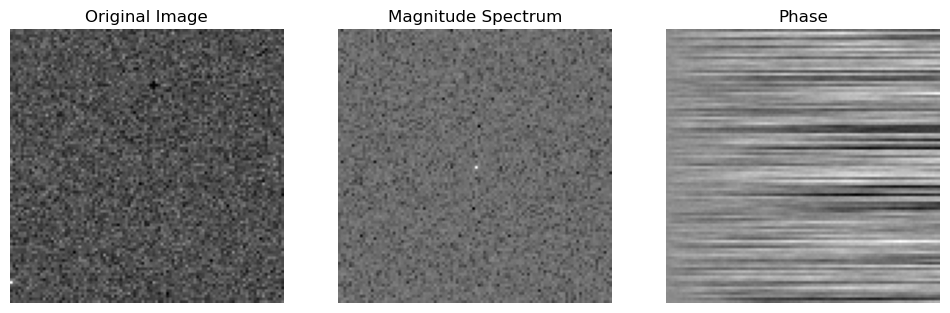

In [262]:
# Load the image
# img_path = './frames/frame_0000.png'
import numpy as np
from matplotlib import pyplot as plt
img_path = './frames/frame_0069.png'
image = Image.open(img_path)

# Convert image to grayscale
image_gray = image.convert('L')

# Convert image to numpy array
image_array = np.array(image_gray)

# Perform 2D FFT
fft2d = np.fft.fft2(image_array)
fft2d_shifted = np.fft.fftshift(fft2d)  # Shift the zero frequency component to the center

# Compute magnitude spectrum
magnitude_spectrum = 20*np.log10(np.abs(fft2d_shifted))  # Use log scale for better visualization

phase = np.unwrap(np.angle(fft2d_shifted))

# Plot the original image and the FFT result
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image_array, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Magnitude Spectrum')
plt.imshow(magnitude_spectrum, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Phase')
plt.imshow(phase, cmap='gray')
plt.axis('off')

plt.show()

## Wavelet analyses

# Filtering techniques

## PCA

(100, 100, 3)


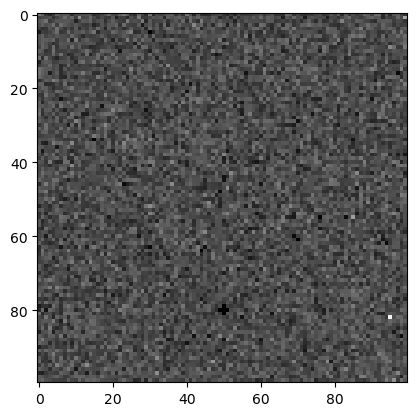

In [221]:
from matplotlib.image import imread
from matplotlib import pyplot as plt
import numpy as np

beeld = imread('./frames/frame_0023.png')
#plt.figure(figsize=[5,5])
plt.figure()
plt.imshow(beeld)
print(beeld.shape)

(100, 100)


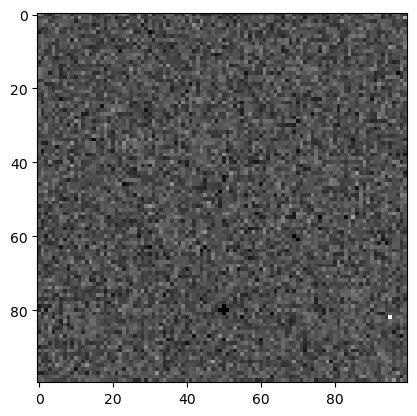

In [222]:
gray = 0.3*beeld[:,:,0] + 0.59*beeld[:,:,1] + 0.11*beeld[:,:,2]
plt.figure
plt.imshow(gray,cmap='gray')
print(gray.shape)

In [223]:
# import cv2
# kernel = 1/32 * np.array([[1, 2, 1],
# [2, 4, 2],
# [1, 2, 1]])

# blurred1 = cv2.filter2D(beeld, -1, kernel)

# plt.figure(figsize=[5,5])
# plt.figure(1)
# plt.title('Original image 1')
# plt.imshow(beeld, cmap='gray')
# plt.figure(figsize=[5,5])
# plt.figure(2)
# plt.title('Gaussian blurred image 1')
# plt.imshow(blurred1, cmap='gray')

In [224]:
# threshold = 0.1 #0.5
# Filtered1 = np.where(blurred1 < threshold, 1, blurred1)

# plt.figure(figsize=[5,5])
# plt.figure(1)
# plt.title('Final filtered image 1')
# plt.imshow(Filtered1, cmap='gray')

In [225]:
# gray = 0.3*blurred1[:,:,0] + 0.59*blurred1[:,:,1] + 0.11*blurred1[:,:,2]
# plt.figure
# plt.imshow(gray,cmap='gray')
# print(gray.shape)

In [226]:
# gray = blurred1
print(gray.shape)

(100, 100)


In [227]:
#####################################____First image____##########################################################
window_size = 10 #10 first try
step = 10 

# Calculate number of windows in each dimension
num_windows_h = (gray.shape[0] - window_size) // step + 1
num_windows_w = (gray.shape[1] - window_size) // step + 1

# Initialize X matrix with zeros
X = np.zeros((window_size * window_size, num_windows_h * num_windows_w))

# Loop over each window and extract pixels
idx = 0
for i in range(num_windows_h):
    for j in range(num_windows_w):
        # Extract window of pixels
        window = gray[i*step:i*step+window_size, j*step:j*step+window_size].reshape(1, -1)
        # Stack window vector onto X matrix
        X[:,idx] = window
        idx += 1
(Nx,Ny) = X.shape
print('Dimensions of X: ')
print(X.shape)

mu = np.mean(X,1)   #calculate mean value
print('Dimension of mu: ')
print(mu.shape)

for n in range(0,Ny):   #get rid of the mean value
  X[:,n] = X[:,n] - mu

Dimensions of X: 
(100, 100)
Dimension of mu: 
(100,)


In [228]:
Cx = np.cov(X,rowvar='true')
print('Dimensions of Cx:')
print(Cx.shape)

Dimensions of Cx:
(100, 100)


In [229]:
# Obtain the eigenvalues and eigenvectors of Cx
eigval, eigvec = np.linalg.eig(Cx)
descending_indices = np.argsort(eigval)[::-1]
sorted_eigvec_descending = eigvec[:, descending_indices]
KumSom = np.cumsum(eigval)
KumSom = 100 * KumSom / np.amax(KumSom)     # normalise as a percentage
print('Dimensions of eigenvector matrix:')
print(eigvec.shape)

Dimensions of eigenvector matrix:
(100, 100)


Text(0, 0.5, 'Precentage contribution [%]')

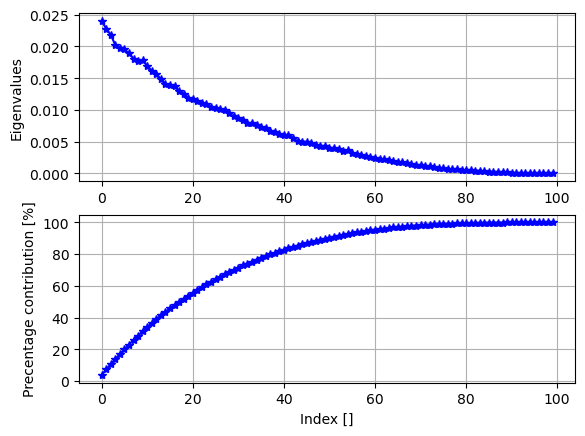

In [230]:
# Plot the scree plot
plt.figure()
plt.subplot(2,1,1)
plt.plot(eigval,'b*-')
plt.ylabel('Eigenvalues')
plt.grid()
# plt.xlim(0,10)
plt.subplot(2,1,2)
plt.plot(KumSom,'b*-')
plt.grid('true')
plt.xlabel('Index []')
plt.ylabel('Precentage contribution [%]')
# plt.xlim(0,10)

Text(0.5, 1.0, 'Eigenvectors used: 1->3')

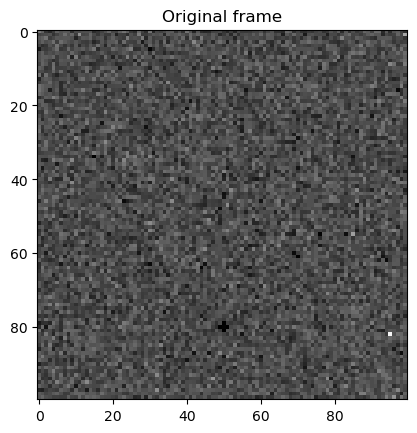

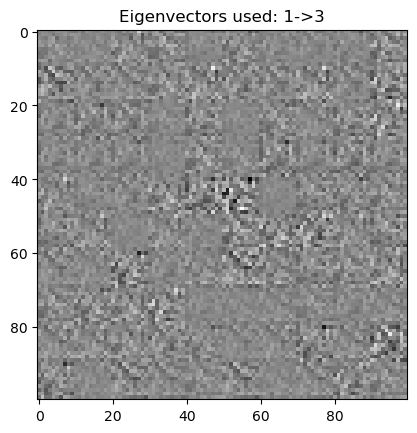

In [233]:
Nwindow = window_size**2                       # number of pixels in window

def Transform_and_Reconstruct(Nstart, Nstop):            
    
    A = np.zeros((Nwindow,Nwindow))  # construct A matrix (with eigenvectors as row vectors)
    for n in range(Nstart,Nstop):
        # A[n,:] = sorted_eigvec[:,n]
        A[n,:] = sorted_eigvec_descending[:,n]
        # print(n)
        

    y = A@X                          # transform signal

    xk = A.T @ y                     # reconstruct signal
    for n in range(0,Ny):
        xk[:,n] = xk[:,n] + mu

    out = np.zeros(gray.shape)
    k = 0
    n = 0

    for i in range(num_windows_h):
        for j in range(num_windows_w):
            out[i*step:i*step+window_size, j*step:j*step+window_size] = xk[:,k].reshape(window_size, window_size)
            k += 1

    return out

startindex = 1  #start @ 1
stopindex = 3   
image_result =  Transform_and_Reconstruct(startindex-1, stopindex)

# Plot the output
plt.figure(1)
plt.imshow(beeld, cmap = 'gray')
plt.title('Original frame')
plt.figure(2)
plt.imshow(image_result, cmap = 'gray')
plt.title('Eigenvectors used: ' + str(startindex) + '->' + str(stopindex))

In [232]:
# threshold = 0.09 #0.5
# Filtered1 = np.where(image_result < threshold, 1, image_result)

# plt.figure(figsize=[5,5])
# plt.figure(1)
# plt.title('Final filtered image 1')
# plt.imshow(Filtered1, cmap='gray')